# Fundamentals of Machine Learning (CSCI-UA.473)

## Lab 4: Multi-class classification, SVMs and Trees

In [1]:
# Load basic packages
import numpy as np
import pandas as pd
# Install autograd:
#!conda install -c conda-forge autograd

import autograd.numpy as numpy
import autograd.numpy.random as npr

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn import metrics
from sklearn import model_selection



# Import and load dataset for this exercise - pip install palmerpenguins
from palmerpenguins import load_penguins
# This function returns a pandas dataframe by default (use return_X_y to get it in two numpy arrays)
penguins = load_penguins().dropna()
X = penguins[['bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g']]
y = penguins['species']
print(X.shape, y.shape)
X.head()

(333, 4) (333,)


,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,39.1,18.7,181.0,3750.0
1,39.5,17.4,186.0,3800.0
2,40.3,18.0,195.0,3250.0
4,36.7,19.3,193.0,3450.0
5,39.3,20.6,190.0,3650.0


### Split the data into train and test

We'll use a 80/20 split for our training/test sets. We will not touch the test set. 

In [2]:
# Split the data.  DO NOT TOUCH THE TEST DATA FROM HERE ON!!
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y, test_size = 0.2) # 0.2 is 20% test data.


## Part I : Multiclass Classification

Multiclass classification is just when we have more than 2 classes.  Instead of modeling the posterior class probabilities as Bernoulli random variables, we can model them as multinomial random variables for example. The penguins dataset we have loaded is an example of a multi-class dataset. In this part we will extend our logistic regression model to classify more than 2 classes.

In [3]:
# Import packages for building the logistic model
from sklearn.linear_model import LogisticRegression


In [4]:
# Get the 2 different models.
model1 = LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg')
model2 = LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg')

# Train the second model on a subset of the features
X_train2 = X_train[['body_mass_g', 'bill_depth_mm']]

For validation purposes we will use cross validation. This is particularly useful in this situation since we only have 344 examples in our dataset. We will use $k$-fold cross-validation with $k=10$.  This works by splitting the training data into 10 disjoint sets.  We then leave out one of these sets and train our model on the remaining 9 sets and treat the left out set as a validation set.  We repeat this a total of 10 times and average the validation scores.  If $k = N$ is the number of samples, then this is also called leave one out cross-validation (LOOCV).  Note that using $k$-fold cross-validation is more expensive than if we had a separate validation set to begin with because we have to train our model many times.

Cross-validation will become more useful when we have a hyperparameter to control during training and want to see which value of the hyperparameter will give the best results.

In [5]:
# k-fold cross-validation.
k = 10
splitter = model_selection.KFold(k)

# Compute cross-validation scores.
cv_scores1 = model_selection.cross_val_score(model1, X_train, y_train, cv = splitter)
cv_scores2 = model_selection.cross_val_score(model2, X_train2, y_train, cv = splitter)

# Print the means of the scores.
print("Model 1 CV score = ", np.mean(cv_scores1))
print("Model 2 CV score = ", np.mean(cv_scores2))

Model 1 CV score =  0.9813390313390313
Model 2 CV score =  0.7750712250712251


### Learning curves

We can also look to see how our two models perform when given additional training examples.  A learning curve shows the tradeoff between the number of samples we use to train and the model's predictive accuracy.  We plot the learning curves for our two models below.

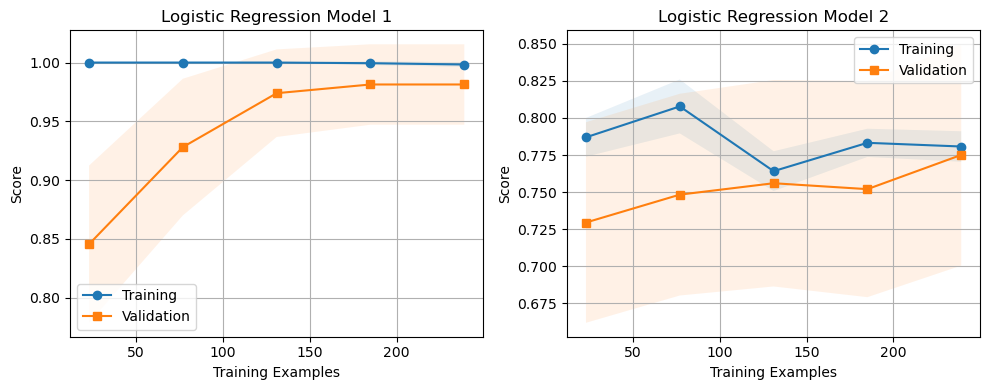

In [6]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,4))

train_sizes1, train_scores1, test_scores1 = model_selection.learning_curve(model1, X_train, y_train, cv = splitter)
train_sizes2, train_scores2, test_scores2 = model_selection.learning_curve(model2, X_train2, y_train, cv = splitter)

# Compute means and std to reflect the stability of the models
train_scores_mean1 = np.mean(train_scores1, axis = 1)
test_scores_mean1  = np.mean(test_scores1, axis = 1)
train_scores_std1  = np.std(train_scores1, axis = 1)
test_scores_std1   = np.std(test_scores1, axis = 1)

train_scores_mean2 = np.mean(train_scores2, axis = 1)
test_scores_mean2  = np.mean(test_scores2, axis = 1)
train_scores_std2  = np.std(train_scores2, axis = 1)
test_scores_std2   = np.std(test_scores2, axis = 1)

ax1.set_title('Logistic Regression Model 1')
ax1.plot(train_sizes1, train_scores_mean1, 'o-', label = 'Training')
ax1.plot(train_sizes1, test_scores_mean1, 's-', label = 'Validation')
ax1.fill_between(train_sizes1, train_scores_mean1 - train_scores_std1, train_scores_mean1 + train_scores_std1, alpha = 0.1)
ax1.fill_between(train_sizes1, test_scores_mean1 - test_scores_std1, test_scores_mean1 + test_scores_std1, alpha = 0.1)
ax1.set_xlabel('Training Examples')
ax1.set_ylabel('Score')
ax1.grid()
ax1.legend()

ax2.set_title('Logistic Regression Model 2')
ax2.plot(train_sizes2, train_scores_mean2, 'o-', label = 'Training')
ax2.plot(train_sizes2, test_scores_mean2, 's-', label = 'Validation')
ax2.fill_between(train_sizes2, train_scores_mean2 - train_scores_std2, train_scores_mean2 + train_scores_std2, alpha = 0.1)
ax2.fill_between(train_sizes2, test_scores_mean2 - test_scores_std2, test_scores_mean2 + test_scores_std2, alpha = 0.1)
ax2.set_xlabel('Training Examples')
ax2.set_ylabel('Score')
ax2.grid()
ax2.legend()

plt.tight_layout();

### Evaluate the models.

Finally, we actually evaluate our two models on our test set.  The first model has a higher cross-validation score so we expect it to do better on the test set.

In [7]:
model1.fit(X_train, y_train)
model2.fit(X_train2, y_train)

pred1 = model1.predict(X_test)

X_test2 = X_test[['body_mass_g', 'bill_length_mm']]
pred2 = model2.predict(X_test2)

# Get the percent of correctly classified results.
acc1 = metrics.accuracy_score(pred1, y_test)
acc2 = metrics.accuracy_score(pred2, y_test)

print("Logistic regression model accuracy (all features) = {:0.1f}%".format(100 * acc1))
print("Logistic regression model accuracy (2 features)   = {:0.1f}%".format(100 * acc2))

Logistic regression model accuracy (all features) = 98.5%
Logistic regression model accuracy (2 features)   = 14.9%


## Part II : Support Vector Machines
We will now play around with the support vector machine. We will first compare them to a standard logistic regression model. Then we will see how they work on datasets which are not linearly separable.

In [8]:
# Start by importing the packages we'll need.
from sklearn.svm import LinearSVC

%matplotlib inline

In [9]:
# Train the linear SVM.

svm = LinearSVC(C = 1, dual = False) # Uses the squared-hinge loss function when fitting the model.
svm.fit(X_train, y_train)

LinearSVC(C=1, dual=False)

In [10]:
# Now evaluate it on the test points.
y_pred = svm.predict(X_test)

acc = metrics.accuracy_score(y_test, y_pred)
print('Linear SVM validation accuracy = {:0.1f}%'.format(100*acc))

Linear SVM validation accuracy = 98.5%


### Case of non-linearly separable dataset

If the data is linearly separable, then a linear SVM should be able to achieve 100% accuracy, as we saw with the penguins dataset. We'll use a synthetic dataset to illustrate when this does not happen and mention some techniques to handle it. This data is drawn from a bi-modal Gaussian mixture model.

In [11]:
"""
Input:
    N : the number of data points

Output:
    X, y : the features and targets of shapes (N,2) and (N, )
"""
def sample_bimodal_data(N):
    
    # The two modes and covariances.
    mu1 = np.asarray([2, 0])
    mu2 = np.asarray([-1, 0])
    
    cov1 = 2 * np.identity(2)
    cov2 = 2 * np.identity(2)
    
    N1 = N//2   # Number of points in first class.
    N2 = N - N1 # Number of points in second class.
    
    # Sample the random points.
    X1 = np.random.multivariate_normal(mu1, cov1, N1)
    X2 = np.random.multivariate_normal(mu2, cov2, N2)
    Y1 = np.zeros(N1)
    Y2 = np.ones(N2)
    
    # Combine the data.
    X = np.vstack((X1, X2))
    Y = np.concatenate((Y1, Y2), axis = None)
    
    return X,Y

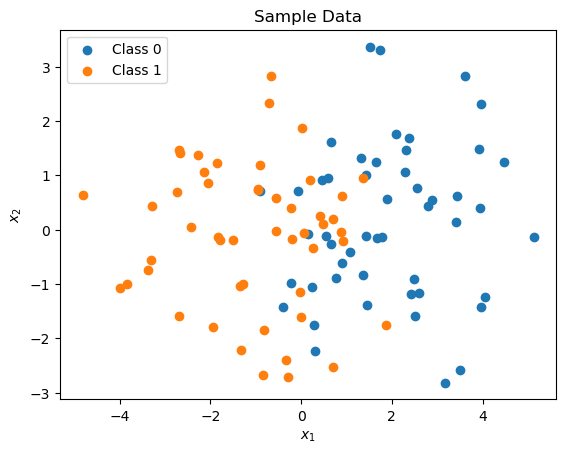

In [12]:
# Plot the sample data.
N = 100
X,Y = sample_bimodal_data(N)

plt.figure(1)
plt.scatter(X[:N//2, 0], X[:N//2, 1], label = 'Class 0')
plt.scatter(X[N - N//2:, 0], X[N - N//2:, 1], label = 'Class 1')
plt.legend()
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title('Sample Data');

Increasing the factor in front of the covariances or shifting the centers of the two distributions to be closer to each other will cause the data to overlap more, making it harder to classify. Lets try that! 

#### Using a slack variable C

Since the data is not perfectly linearly separable you'll want to use a slack variable which allows SVM to handle this dataset.  Let's train some models with different values of $C$ and compare them using cross-validation.

In [13]:
# First get the data and split it into training and testing.

N = 100
Xs, Ys = sample_bimodal_data(N)

# Use a 70/30 split, normally we would want 3 splits (including the validation), but in this example we will use sklearn's cross_val_score function to tune our hyperparameters
# This means that we are doing k-fold leave one out cross validation and different subsets of our training set will be used as validation sets.
Xs_train, Xs_test, Ys_train, Ys_test = model_selection.train_test_split(Xs, Ys, test_size = 0.30, random_state = 981)

SVM accuracy = 76.7%


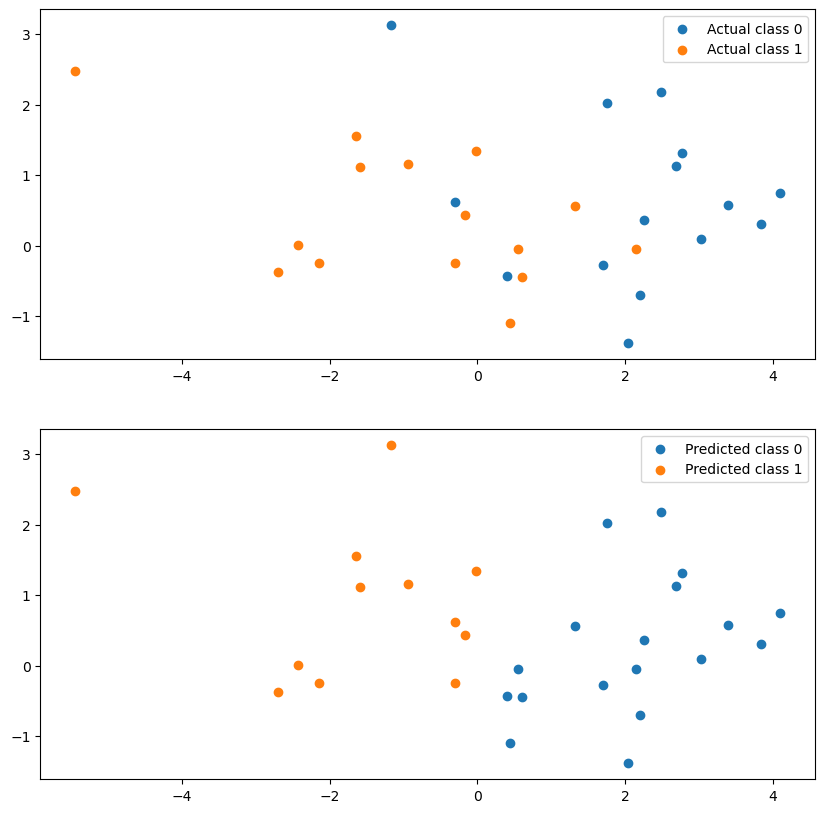

In [16]:
# Define the SVM model to use with a slack variable, remember that C here controls the "inverse" regularization strength since by decreasing
# C we allow more points to lie beyond the correct margin.
svm = LinearSVC(C = 1e-10, dual = False)
svm.fit(Xs_train, Ys_train)
svmpred = svm.predict(Xs_test)
acc = metrics.accuracy_score(Ys_test, svmpred)
print('SVM accuracy = {:0.1f}%'.format(100*acc))
fig, axs = plt.subplots(2, figsize=(10,10))

# Select indices with certain class, this is useful while indexing from larger arrays
I = Ys_test == 0
axs[0].scatter(Xs_test[I, 0], Xs_test[I, 1], label = 'Actual class 0')
I = Ys_test == 1
axs[0].scatter(Xs_test[I, 0], Xs_test[I, 1], label = 'Actual class 1')
axs[0].legend()
I = svmpred == 0
axs[1].scatter(Xs_test[I, 0], Xs_test[I, 1], label = 'Predicted class 0')
I = svmpred == 1
axs[1].scatter(Xs_test[I, 0], Xs_test[I, 1], label = 'Predicted class 1')


plt.legend()
plt.show()

**Experiment with various different mu1 values and demonstrate SVM accuracy gets worse as mu1 and mu2 get closer**


Let's train some models with different $C$ and compare them use cross-validation.

In [17]:
# Define the different SVM models to use
svm_1 = LinearSVC(C = 10, dual = False)
svm_2 = LinearSVC(C = 1, dual = False)
svm_3 = LinearSVC(C = 1e-2, dual = False)
svm_4 = LinearSVC(C = 1e-10, dual = False)

split = model_selection.KFold(5)
# Get the CV scores.
cv_1 = model_selection.cross_val_score(svm_1, Xs_train, Ys_train, cv = split)
cv_2 = model_selection.cross_val_score(svm_2, Xs_train, Ys_train, cv = split)
cv_3 = model_selection.cross_val_score(svm_3, Xs_train, Ys_train, cv = split)
cv_4 = model_selection.cross_val_score(svm_4, Xs_train, Ys_train, cv = split)

# Print the average scores.
print('C = 10    CV average score = {:0.1f}%'.format(np.mean(cv_1) * 100))
print('C = 1     CV average score = {:0.1f}%'.format(np.mean(cv_2) * 100))
print('C = 1e-3  CV average score = {:0.1f}%'.format(np.mean(cv_3) * 100))
print('C = 1e-7  CV average score = {:0.1f}%'.format(np.mean(cv_4) * 100))

C = 10    CV average score = 84.3%
C = 1     CV average score = 84.3%
C = 1e-3  CV average score = 85.7%
C = 1e-7  CV average score = 87.1%


We see that the model performs slightly differently for different values of the slack variable $C$.  

$$
\min_{w,b,\zeta} \frac{1}{2}w^Tw + C\sum_{i=1}^n \zeta_i,\quad \text{ such that }\quad y_i(w^Tx_i + b) \ge 1 - \zeta_i,\quad \zeta_i \ge 0
$$

See the sci-kit [documentation](https://scikit-learn.org/stable/modules/svm.html) for more details.  We can also plot a curve of the validation score for many different $C$ values which can be helpful for determining the optimal hyperparameter.

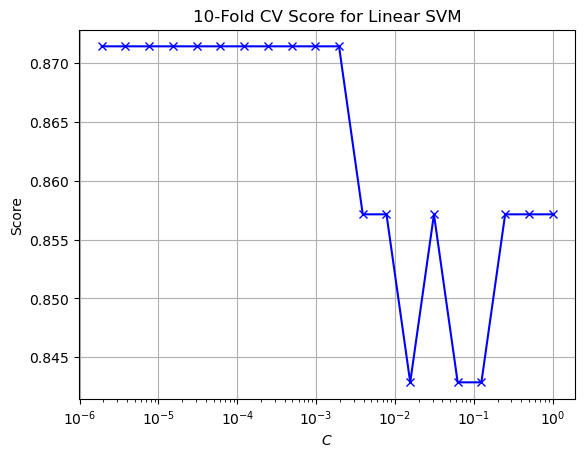

In [18]:
# Get the C values we want to look at.
C = 1/(2**np.arange(0, 20)) # 1,...,1e-6

k = 10 # Kfold CV.
cv_scores = np.zeros(len(C))
split = model_selection.KFold(k)
for i in range(len(C)):
    svm = LinearSVC(C = C[i], dual = False)
    cv_scores[i] = np.mean(model_selection.cross_val_score(svm, Xs_train, Ys_train, cv = split))

plt.figure(2)
plt.semilogx(C, cv_scores, 'b-x')
plt.xlabel(r'$C$')
plt.ylabel(r'Score')
plt.title(r'{:d}-Fold CV Score for Linear SVM'.format(k))
plt.grid();

We can use this plot to find the optimal value of the slack variables based on the cross validation score. Now let's see how our 4 models from earlier actually do on the validation set.

In [17]:
# Define the different SVM models to use
svm_1 = LinearSVC(C = 10, dual = False)
svm_2 = LinearSVC(C = 1, dual = False)
svm_3 = LinearSVC(C = 1e-3, dual = False)
svm_4 = LinearSVC(C = 1e-7, dual = False)

# Fit the models.
svm_1.fit(Xs_train, Ys_train)
svm_2.fit(Xs_train, Ys_train)
svm_3.fit(Xs_train, Ys_train)
svm_4.fit(Xs_train, Ys_train)

# Make the predictions.
pred1 = svm_1.predict(Xs_test)
pred2 = svm_2.predict(Xs_test)
pred3 = svm_3.predict(Xs_test)
pred4 = svm_4.predict(Xs_test)

# Evaluate the models.
acc1 = metrics.accuracy_score(Ys_test, pred1)
acc2 = metrics.accuracy_score(Ys_test, pred2)
acc3 = metrics.accuracy_score(Ys_test, pred3)
acc4 = metrics.accuracy_score(Ys_test, pred4)

print('Linear SVM (C = 10)   accuracy = {:0.1f}%'.format(100*acc1))
print('Linear SVM (C = 1)    accuracy = {:0.1f}%'.format(100*acc2))
print('Linear SVM (C = 1e-3) accuracy = {:0.1f}%'.format(100*acc3))
print('Linear SVM (C = 1e-7) accuracy = {:0.1f}%'.format(100*acc4))

Linear SVM (C = 10)   accuracy = 73.3%
Linear SVM (C = 1)    accuracy = 73.3%
Linear SVM (C = 1e-3) accuracy = 76.7%
Linear SVM (C = 1e-7) accuracy = 76.7%


### Another non-linearly separable dataset

In [18]:
"""
Input:
    N : the number of data points

Output:
    X, y : the features and targets of shapes (N,2) and (N, )
"""
def gen_data1(N):
    N1 = N//2
    N2 = N - N1
    t = np.linspace(0, 2*np.pi, N1)
    
    X1 = np.zeros((N1, 2))
    X1[:,0] = 4*np.cos(t) + 0.1*np.random.randn(N1)
    X1[:,1] = 4*np.sin(t) + 0.1*np.random.randn(N1)
    y1 = np.zeros(N1)
    
    X2 = np.random.randn(2*N2)
    X2 = X2.reshape((N2, 2))
    y2 = np.ones(N2)

    # Combine the data.
    X = np.vstack((X1, X2))
    y = np.concatenate((y1, y2), axis = None) # axis = None means that arrays flattened before use
    
    return X,y

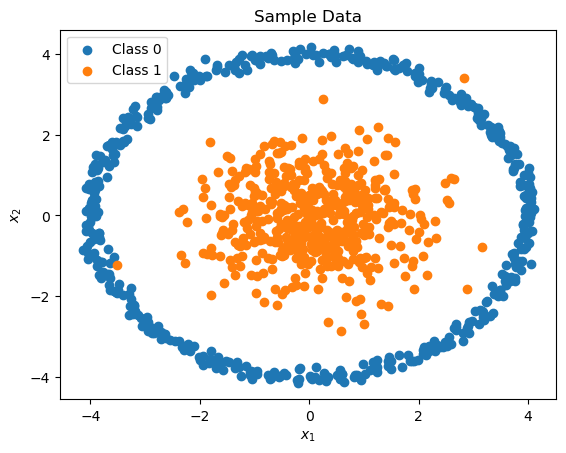

In [19]:
# Plot the data.
N = 1000
Xs, Ys = gen_data1(N)

plt.figure(3)
plt.scatter(Xs[:N//2, 0], Xs[:N//2, 1], label = 'Class 0')
plt.scatter(Xs[N - N//2:, 0], Xs[N - N//2:, 1], label = 'Class 1')
plt.legend()
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title('Sample Data');

SVM accuracy = 43.3%


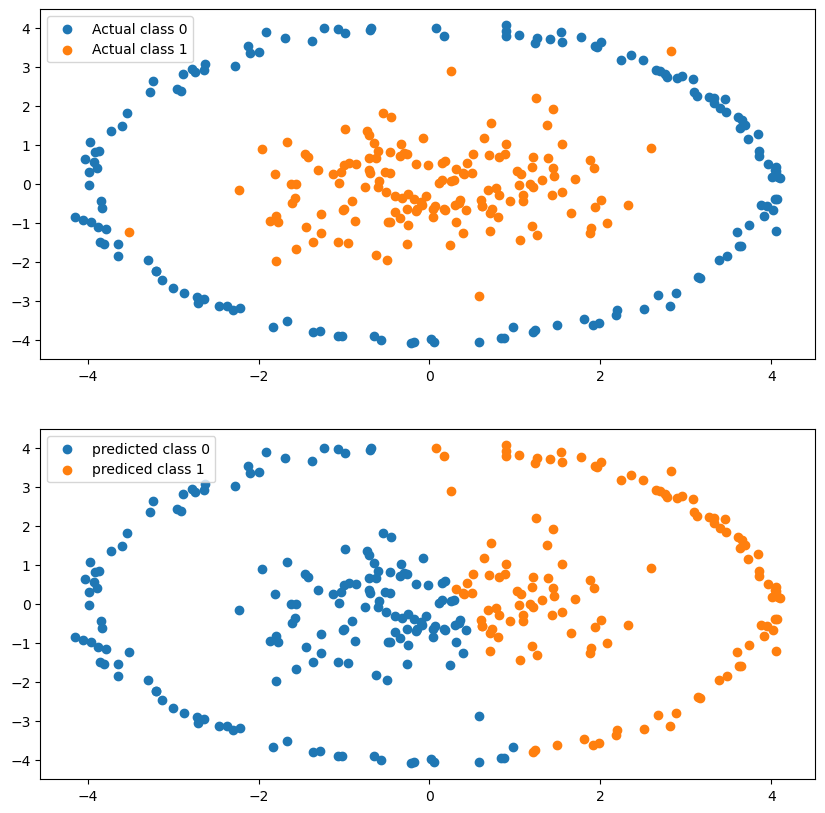

In [20]:
# Define the different SVM models to use
# Use a 70/30 split, we are not performing any validation steps here
Xs_train, Xs_test, Ys_train, Ys_test = model_selection.train_test_split(Xs, Ys, test_size = 0.3, random_state = 981)
svm = LinearSVC(C = 1e+10, dual = False)
svm.fit(Xs_train, Ys_train)
svmpred = svm.predict(Xs_test)
acc = metrics.accuracy_score(Ys_test, svmpred)
print('SVM accuracy = {:0.1f}%'.format(100*acc))

fig, axs = plt.subplots(2, figsize=(10,10))

# Select indices with certain class, this is useful while indexing from larger arrays
I = Ys_test == 0
axs[0].scatter(Xs_test[I, 0], Xs_test[I, 1], label = 'Actual class 0')
I = Ys_test == 1
axs[0].scatter(Xs_test[I, 0], Xs_test[I, 1], label = 'Actual class 1')
axs[0].legend()
I = svmpred == 0
axs[1].scatter(Xs_test[I, 0], Xs_test[I, 1], label = 'predicted class 0')
I = svmpred == 1
axs[1].scatter(Xs_test[I, 0], Xs_test[I, 1], label = 'prediced class 1')
plt.legend()
plt.show()

(1000, 2)


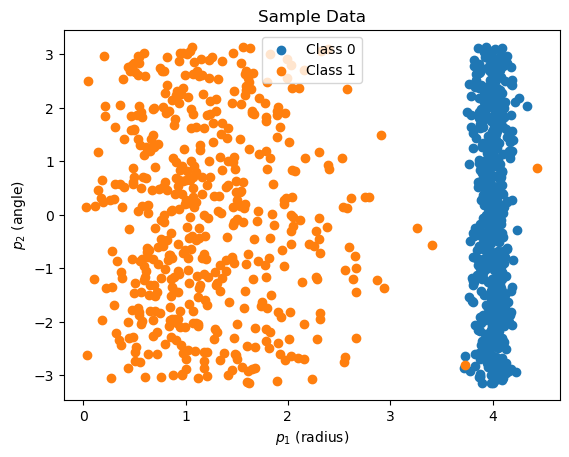

In [21]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return (rho, phi)

pX = np.vstack(cart2pol(Xs[:, 0], Xs[:, 1])).T
print(pX.shape)
plt.figure(4)
plt.scatter(pX[:N//2, 0], pX[:N//2, 1], label = 'Class 0')
plt.scatter(pX[N - N//2:, 0], pX[N - N//2:, 1], label = 'Class 1')
plt.legend()
plt.xlabel(r'$p_1$ (radius)')
plt.ylabel(r'$p_2$ (angle)')
plt.title('Sample Data')
plt.show()

In [22]:
# Define the different SVM models to use
# Use a 70/30 split
Xs_train, Xs_val, Ys_train, Ys_val = model_selection.train_test_split(pX, Ys, test_size = 0.3, random_state = 981)
svm = LinearSVC(C = 1e+10, dual = False)
svm.fit(Xs_train, Ys_train)
svmpred = svm.predict(Xs_val)
acc = metrics.accuracy_score(Ys_val, svmpred)
print('SVM accuracy = {:0.1f}%'.format(100*acc))

SVM accuracy = 99.3%


## Part III : Trees - Decisions Trees, Random Forests and Adaboost

In [23]:
from sklearn import tree

In [24]:
# Initialize a simple decision tree classifier
clf = tree.DecisionTreeClassifier(criterion='gini')

# Fit our penguins data on this, rememeber we had already split this dataset at the begining and should use the same splits across methods
# if we want to compare the performance.
clf = clf.fit(X_train, y_train)


In [25]:
# Predict using the fitted decision tree
preds = clf.predict(X_test)
print(np.sum(preds == y_test)/len(preds))

0.9552238805970149


In [26]:
# This was your vanilla Decision trees, now lets look at Bagging.
from sklearn.ensemble import BaggingClassifier

# Remember, Bagging is just using an ensemble of decision trees to add more variance to your model.
# So we simply wrap our original DecisionTreeClassifier with a BaggingClassifier module.
clf = BaggingClassifier(base_estimator=tree.DecisionTreeClassifier(criterion='gini'),
                       n_estimators=100, max_samples=1.0, max_features=0.5,bootstrap=True)
clf = clf.fit(X_train, y_train)
# What would setting n_estimators as 1 mean?
# Changing the value for n_estimators changes our accuracy


In [27]:
preds = clf.predict(X_test)
print(np.sum(preds == y_test)/len(preds))

0.9701492537313433


In [28]:
# Random forests
from sklearn.ensemble import RandomForestClassifier

# Now we try RandomForests on the same data. Again, RandomForests is just a method to ensemble your base models
# and will be used in the same way bagging was. The difference is in the number of features being selected to make a node split
clf = RandomForestClassifier(n_estimators=1000, max_samples=0.1, max_features=0.5,bootstrap=True, criterion='gini')
clf.fit(X_train, y_train)

RandomForestClassifier(max_features=0.5, max_samples=0.1, n_estimators=1000)

In [29]:
preds = clf.predict(X_test)
print(np.sum(preds == y_test)/len(preds))

0.9552238805970149


In [30]:
# Next we implement gradient boosting, in particular the Adaboost algorithm.
# Remember, gradient boosting algorithms involve iteratively improving the decision trees
# and hence involve a learning rate similar to logistic regressions.
from sklearn.ensemble import AdaBoostClassifier

In [31]:
# Create and fit an AdaBoosted decision tree
bdt = AdaBoostClassifier(
    tree.DecisionTreeClassifier(max_depth=1), algorithm="SAMME", n_estimators=2000, learning_rate=1
)
bdt.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=1, n_estimators=2000)

In [32]:
preds = bdt.predict(X_test)
print(np.sum(preds == y_test)/len(preds))

0.9402985074626866


### Using a synthetic dataset to visualize effects of different hyperparameters

In [33]:
from sklearn.datasets import make_gaussian_quantiles

# Construct dataset
X1, y1 = make_gaussian_quantiles(
    cov=2.0, n_samples=200, n_features=2, n_classes=2, random_state=1
)
X2, y2 = make_gaussian_quantiles(
    mean=(3, 3), cov=1.5, n_samples=300, n_features=2, n_classes=2, random_state=1
)
X = np.concatenate((X1, X2))
y = np.concatenate((y1, -y2+1))

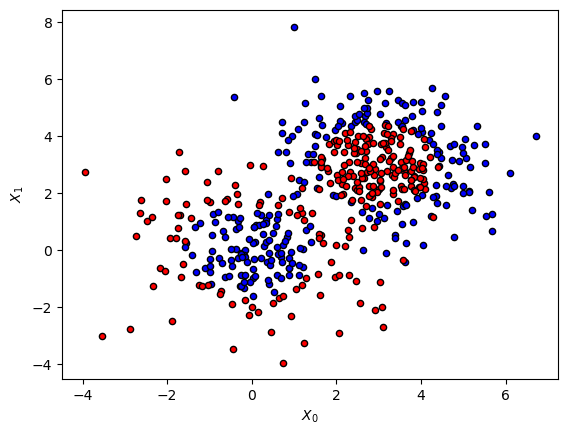

In [34]:
# Plot the training points
plot_colors = "br"
plot_step = 0.02
class_names = "AB"
for i, n, c in zip(range(2), class_names, plot_colors):
    idx = np.where(y == i)
    plt.scatter(
        X[idx, 0],
        X[idx, 1],
        c=c,
        cmap=plt.cm.Paired,
        s=20,
        edgecolor="k",
        label="Class %s" % n,
    )
    plt.xlabel(r'$X_0$')
    plt.ylabel(r'$X_1$')

In [35]:
# Create and fit an AdaBoosted decision tree
bdt = AdaBoostClassifier(
    tree.DecisionTreeClassifier(max_depth=1), algorithm="SAMME", n_estimators=2000, learning_rate=1
)
bdt.fit(X, y)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=1, n_estimators=2000)

Text(0.5, 1.0, 'Decision Boundary')

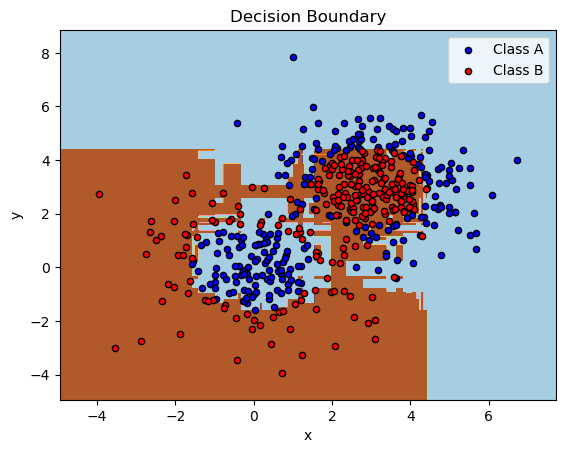

In [36]:
# Initialize the plots
plt.subplot(111)
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step)
)

# Make predictions using fitted tree
Z = bdt.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
plt.axis("tight")

# Plot the training points
for i, n, c in zip(range(2), class_names, plot_colors):
    idx = np.where(y == i)
    plt.scatter(
        X[idx, 0],
        X[idx, 1],
        c=c,
        cmap=plt.cm.Paired,
        s=20,
        edgecolor="k",
        label="Class %s" % n,
    )
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend(loc="upper right")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Decision Boundary")